# Figures 7-8

Welcome to the jupyter notebook for the GitHub repository of the paper "Biophysical models reveal the relative importance of transporter proteins and impermeant anions in chloride homeostasis" (currently in review, view at https://www.biorxiv.org/content/early/2017/11/08/216150). This notebook is designed to allow you to run and tweak the code and see the associated Figures 7-8 in the paper (i.e. the figures generated using a multi-compartment model of chloride homeostasis).

You may also wish to explore the code in your favourite python3 environment, as the figures generated in this notebook are static and one can generate figures that update while a simulation runs to explore other parameters and compartment set-ups. However, the simulations are slow and you can expect a decent-length simulation to take several hours to run.

In [1]:
import sys, getopt
from simulator import Simulator
from compartment import Compartment
from diffusion import Diffusion
from common import default_radius_short
from colormap import Colormap
from main import print_concentrations

time_per_sim = 15 # time_per_sim is the time for which each 'step' of the simulation runs

def baserun(cli_D=2.03, new_gx=0e-8, anion_flux=False, default_xz=-0.85, jkccup=1e-12, nrcomps=2, dz=1e-7, textra=10):
    
    sim = Simulator().get_instance()
    
    dt = 0.001  # s

    length = 10e-5
    
    pui = 500

    comp = Compartment("reference", z=-0.85
                       , cli=0.0052,
                       ki=0.0123,
                       nai=0.014,
                       length=length,
                       radius=default_radius_short)

    # copies left
    compl = comp.copy("dendrite left")

    # copies right
    compr = []
    compr.append(comp.copy("dendrite right " + str(1)))
    for i in range(nrcomps):
        compr.append(comp.copy("dendrite right " + str(i + 2)))

    # find steady-state values of ions
    sim.run(stop=100, dt=0.001, plot_update_interval=pui, data_collect_interval=5, block_after=False)
    
    # instantiate gui
    gui = sim.gui()
        
    # set diffusion value
    cli_D *= 1e-7  # cm2 to dm2 (D in dm2/s)
    ki_D = 1.96
    ki_D *= 1e-7  # cm2 to dm2 (D in dm2/s)
    nai_D = 1.33
    nai_D *= 1e-7
    diffusion_object = []

    # connect with Diffusion
    diffusion_object.append(Diffusion(compl, comp, ions={'cli': cli_D, 'ki': ki_D, 'nai': nai_D}))
    diffusion_object.append(Diffusion(comp, compr[0], ions={'cli': cli_D, 'ki': ki_D, 'nai': nai_D}))
    for i in range(nrcomps):
        diffusion_object.append(Diffusion(compr[i], compr[i+1], ions={'cli': cli_D, 'ki': ki_D, 'nai': nai_D}))

    # heatmap incorporating compartment dimensions (not to scale, but relative differences over time are preserved)
    sc = 1e7
    htplot = Colormap("cmap",0,compr)
    totalht, initvals = htplot.heatmap(compl, comp, compr, sc, 0, all=1, init_vals=None)

    # plot of compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp = gui.add_graph() \
        .add_ion_conc(comp, "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(comp, "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(comp, line_style='k', y_units_scale=1000, y_plot_units='mV')
    
    # plot of furthest compartment from the compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp_end = gui.add_graph() \
        .add_ion_conc(compr[-1], "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(compr[-1], "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(compr[-1], line_style='k', y_units_scale=1000, y_plot_units='mV')
    
    # run simulation with diffusion
    sim.run(continuefor=10, dt=dt, plot_update_interval=10, data_collect_interval=2)
    print_concentrations([comp, compl, compr[-1]],
                         title="Ion concentrations given diffusion between compartments")
    
    # heatmap incorporating compartment dimensions (not to scale, but relative differences over time are preserved)
    htplot.heatmap(compl, comp, compr, sc, totalht, all=1, init_vals=initvals,title=['Initial Driving Force Difference','Initial ECl Difference','Initial Vm difference'])
    
    # (optionally) change anion conductance
    prev_comp_gx = comp.gx
    comp.gx = new_gx
    comp.dz = dz
    
    # (optionally) change anion flux
    if anion_flux:
        comp.xz = default_xz
        comp.xmz = (comp.z * comp.xi - comp.xz * comp.xi_temp) / comp.xm
        print('Anion flux with fixed anions having net charge', comp.xmz, 'while a proportion of', (1 - comp.ratio),
              'of all impermeants are temporarily mobile anions of charge', comp.xz)
    
    # (optionally) change kcc2
    prev_comp_pkcc2 = comp.pkcc2
    if jkccup is not None:
        comp.jkccup = jkccup
    
    # plot of compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp = gui.add_graph() \
        .add_ion_conc(comp, "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(comp, "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(comp, line_style='k', y_units_scale=1000, y_plot_units='mV')
    
    # plot of furthest compartment from the compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp_end = gui.add_graph() \
        .add_ion_conc(compr[-1], "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(compr[-1], "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(compr[-1], line_style='k', y_units_scale=1000, y_plot_units='mV')

    sim.run(continuefor=textra, dt=dt*0.001, plot_update_interval=textra, data_collect_interval=textra/10.0)

    print_concentrations([comp, compl, compr[-1]],
                         title="Ion concentrations during event from the dendritic compartment")
    
    # heatmap incorporating compartment dimensions (not to scale, but relative differences over time are preserved)
    htplot.heatmap(compl, comp, compr, sc, totalht, all=1, init_vals=initvals, title=['Intermediate Driving Force Difference','Intermediate ECl Difference','Intermediate Vm difference'])
    
    # plot of compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp = gui.add_graph() \
        .add_ion_conc(comp, "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(comp, "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(comp, line_style='k', y_units_scale=1000, y_plot_units='mV')
    
    # plot of furthest compartment from the compartment in which change is happening for the time period of the next sim.run
    voltage_reversal_graph_comp_end = gui.add_graph() \
        .add_ion_conc(compr[-1], "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
        .add_ion_conc(compr[-1], "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
        .add_voltage(compr[-1], line_style='k', y_units_scale=1000, y_plot_units='mV')

    sim.run(continuefor=textra, dt=dt*0.001, plot_update_interval=textra, data_collect_interval=textra/10.0)
    
    voltage_reversal_graph_comp_end.show()
    
    print_concentrations([comp, compl, compr[-1]],
                         title="Ion concentrations immediately after event from the dendritic compartment")
    
    # reset anion flux, kcc2 strength change parameters
    comp.gx = prev_comp_gx
    comp.jkccup = 0
    comp.dz = 0

    #htplot.heatmap(compl, comp, compr, sc, totalht, all=1, init_vals=initvals, title=['Immediate Driving Force Difference','Immediate ECl Difference','Immediate Vm difference'])
    
    if jkccup != 0: # KCC2 methods stabilise quicker than anion flux methods
            
        # plot of compartment in which change is happening for the time period of the next sim.run
        voltage_reversal_graph_comp = gui.add_graph() \
            .add_ion_conc(comp, "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
            .add_ion_conc(comp, "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
            .add_voltage(comp, line_style='k', y_units_scale=1000, y_plot_units='mV')

        # plot of furthest compartment from the compartment in which change is happening for the time period of the next sim.run
        voltage_reversal_graph_comp_end = gui.add_graph() \
            .add_ion_conc(compr[-1], "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
            .add_ion_conc(compr[-1], "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
            .add_voltage(compr[-1], line_style='k', y_units_scale=1000, y_plot_units='mV')

        sim.run(continuefor=textra*2, dt=dt*0.001, plot_update_interval=textra*2, data_collect_interval=textra/10.0)
        
        print_concentrations([comp, compl, compr[-1]],
                         title="Ion concentrations at steady state")
        
        # heatmap incorporating compartment dimensions (not to scale, but relative differences over time are preserved)
        htplot.heatmap(compl, comp, compr, sc, totalht, all=1, init_vals=initvals, title=['Final Driving Force Difference','Final ECl Difference','Final Vm difference'])
    
    else:
        
        # plot of compartment in which change is happening for the time period of the next sim.run
        voltage_reversal_graph_comp = gui.add_graph() \
            .add_ion_conc(comp, "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
            .add_ion_conc(comp, "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
            .add_voltage(comp, line_style='k', y_units_scale=1000, y_plot_units='mV')

        # plot of furthest compartment from the compartment in which change is happening for the time period of the next sim.run
        voltage_reversal_graph_comp_end = gui.add_graph() \
            .add_ion_conc(compr[-1], "ecl", line_style='g', y_units_scale=1000, y_plot_units='mV') \
            .add_ion_conc(compr[-1], "ek", line_style='b', y_units_scale=1000, y_plot_units='mV') \
            .add_voltage(compr[-1], line_style='k', y_units_scale=1000, y_plot_units='mV')
        
        sim.run(continuefor=textra*4, dt=dt*0.001, plot_update_interval=textra*4, data_collect_interval=textra/10.0)
        
        print_concentrations([comp, compl, compr[-1]],
                             title="Ion concentrations at steady state")

        # heatmap incorporating compartment dimensions (not to scale, but relative differences over time are preserved)
        htplot.heatmap(compl, comp, compr, sc, totalht, all=1, init_vals=initvals, title=['Final Driving Force Difference','Final ECl Difference','Final Vm difference'])
        
    sim.dispose()

    return sim, gui

## Figure 7a,b

Figure 7A
Compartment reference not osmo-neutral
Compartment dendrite left not osmo-neutral
Compartment dendrite right 1 not osmo-neutral
Compartment dendrite right 2 not osmo-neutral
Compartment dendrite right 3 not osmo-neutral
Compartment dendrite right 4 not osmo-neutral
Compartment dendrite right 5 not osmo-neutral
Compartment dendrite right 6 not osmo-neutral
Compartment dendrite right 7 not osmo-neutral
Compartment dendrite right 8 not osmo-neutral
running from 0.000000 s until 100.000000 s with time step of 0.001 seconds 


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


time taken: 40.20407
dendrite left<-reference
reference<-dendrite right 1
dendrite right 1<-dendrite right 2
dendrite right 2<-dendrite right 3
dendrite right 3<-dendrite right 4
dendrite right 4<-dendrite right 5
dendrite right 5<-dendrite right 6
dendrite right 6<-dendrite right 7
dendrite right 7<-dendrite right 8
running from 100.000000 s until 110.000000 s with time step of 0.001 seconds 
time taken: 48.32106
Ion concentrations given diffusion between compartments
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.005167863400916091	0.005167863400916091	0.005167863400916091	
ki        0.122795736461747948	0.122795736461747948	0.122795736461747948	
nai       0.014001447398877617	0.014001447398877617	0.014001447398877617	
xi        0.155034952738455439	0.155034952738455439	0.155034952738455439	
pkcc2     0.000000020728539769	0.000000020728539769	0.000000020728539769	
gx        0.000000000000000000	0.000000000000000000	0.000000000000000000	
w      

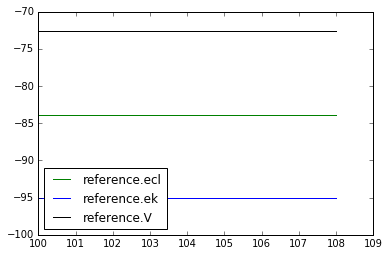

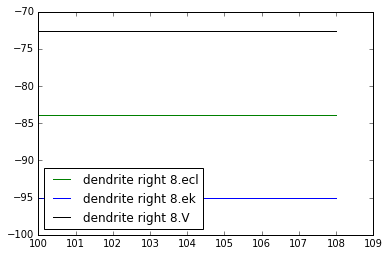

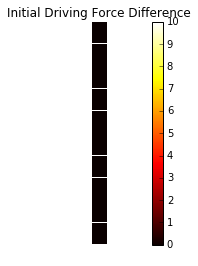

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


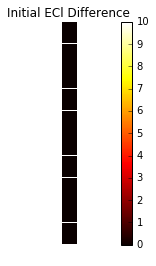

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


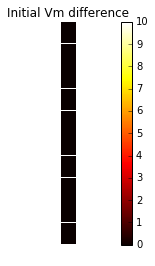

running from 110.000000 s until 125.000000 s with time step of 1e-06 seconds 
time taken: 11725.644542
Ion concentrations during event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.004232835547335874	0.004243900385970805	0.004520245888092875	
ki        0.122673843440728181	0.122676202460215183	0.122718921340783951	
nai       0.014042247321915235	0.014040828082903651	0.014021627753715975	
xi        0.156042263749636451	0.156030340693948555	0.155732594845859579	
pkcc2     0.000000320728539737	0.000000020728539769	0.000000020728539769	
gx        0.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000001249	0.000000000000001250	0.000000000000001252	
ecl       -0.089166827082675565	-0.089097053471057577	-0.087411038987590228	
V         -0.073440009443238086	-0.073438226440110027	-0.073384636312995855	
z         -0.850000000000000089	-0.849999999999999867	-0.849999999999999756	
Radii: [19

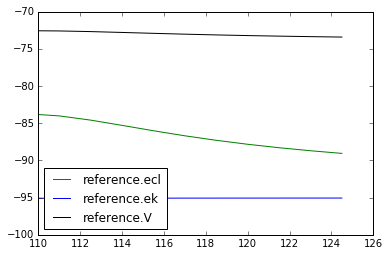

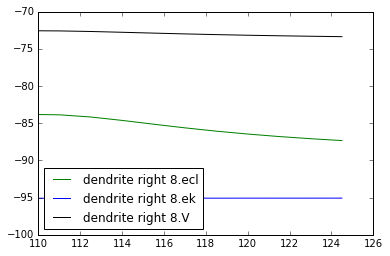

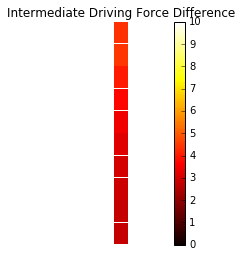

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


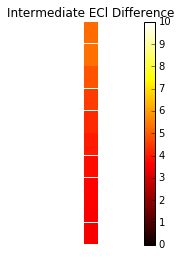

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


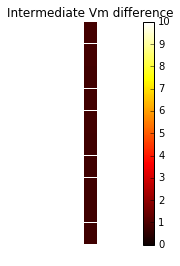

running from 125.000000 s until 140.000000 s with time step of 1e-06 seconds 
time taken: 23255.148827


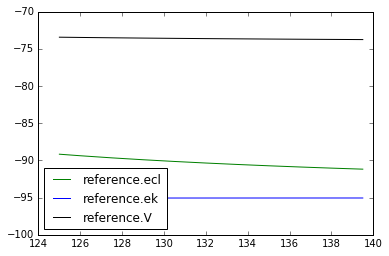

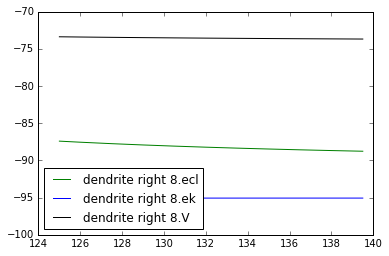

Ion concentrations immediately after event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.003919452190981803	0.003933884673064774	0.004291741369716128	
ki        0.122637433044984284	0.122640481051364880	0.122695129789323398	
nai       0.014055310816479557	0.014053455223546693	0.014028420091165682	
xi        0.156384482172692879	0.156368890933170440	0.155982328009053067	
pkcc2     0.000000620728539999	0.000000020728539769	0.000000020728539769	
gx        0.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000001247	0.000000000000001247	0.000000000000001250	
ecl       -0.091222646940230884	-0.091124412940739863	-0.088797452795368881	
V         -0.073767665331732471	-0.073765343356499646	-0.073695321803287792	
z         -0.850000000000000089	-0.850000000000000089	-0.850000000000000089	
running from 140.000000 s until 170.000000 s with time step of 1e-06 seconds 
time taken: 46079.280771

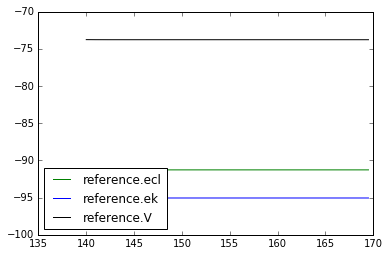

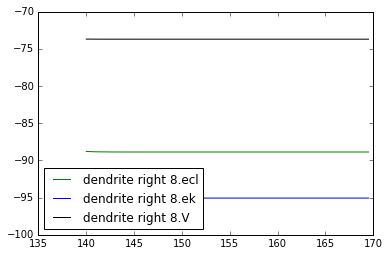

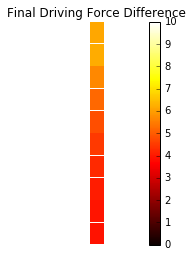

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


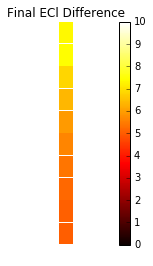

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


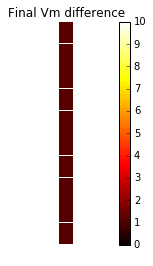

In [2]:
print("Figure 7A")
[sim, gui] = baserun(new_gx=0, jkccup=1e-14, anion_flux=False, default_xz=-1, nrcomps=7, dz=0, textra=time_per_sim)

Figure 7B
Compartment reference not osmo-neutral
Compartment dendrite left not osmo-neutral
Compartment dendrite right 1 not osmo-neutral
Compartment dendrite right 2 not osmo-neutral
Compartment dendrite right 3 not osmo-neutral
Compartment dendrite right 4 not osmo-neutral
Compartment dendrite right 5 not osmo-neutral
Compartment dendrite right 6 not osmo-neutral
Compartment dendrite right 7 not osmo-neutral
Compartment dendrite right 8 not osmo-neutral
running from 170.000000 s until 100.000000 s with time step of 0.001 seconds 
time taken: 46117.958982
dendrite left<-reference
reference<-dendrite right 1
dendrite right 1<-dendrite right 2
dendrite right 2<-dendrite right 3
dendrite right 3<-dendrite right 4
dendrite right 4<-dendrite right 5
dendrite right 5<-dendrite right 6
dendrite right 6<-dendrite right 7
dendrite right 7<-dendrite right 8
running from 100.000000 s until 110.000000 s with time step of 0.001 seconds 
time taken: 46125.844946
Ion concentrations given diffusion b

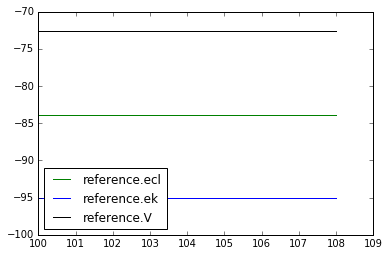

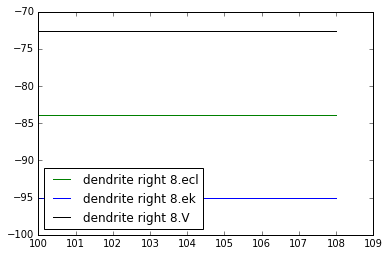

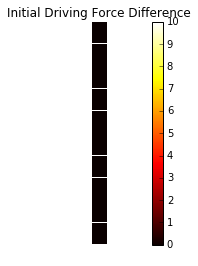

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


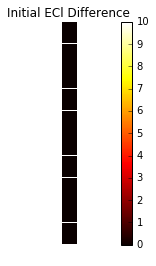

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


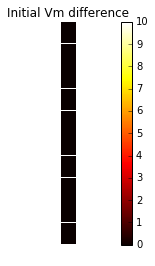

running from 110.000000 s until 125.000000 s with time step of 1e-06 seconds 
time taken: 58168.771505
Ion concentrations during event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.003960800116399973	0.004089524924443612	0.004989317195527234	
ki        0.122670050131897787	0.122680855919148443	0.122762336720516896	
nai       0.014024882772455944	0.014024852452547698	0.014018843571102063	
xi        0.156336950951911718	0.156198107828350446	0.155227724574327652	
pkcc2     0.000000320728539737	0.000000020728539769	0.000000020728539769	
gx        0.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000001247	0.000000000000001248	0.000000000000001256	
ecl       -0.090942173146570646	-0.090087381270605060	-0.084772245367876364	
V         -0.073181674075411859	-0.073181827342238479	-0.073166451487316722	
z         -0.849999999999999978	-0.849999999999999978	-0.850000000000000089	
Radii: [19

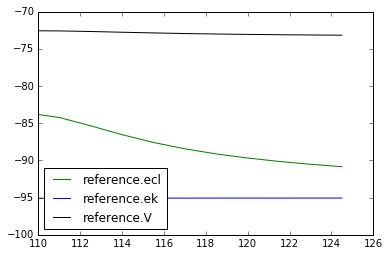

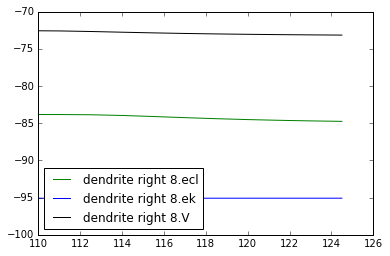

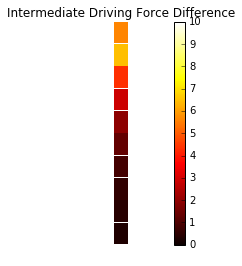

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


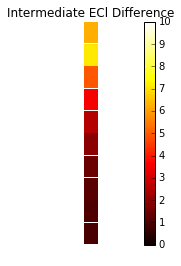

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


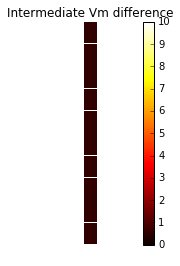

running from 125.000000 s until 140.000000 s with time step of 1e-06 seconds 
time taken: 69807.142339


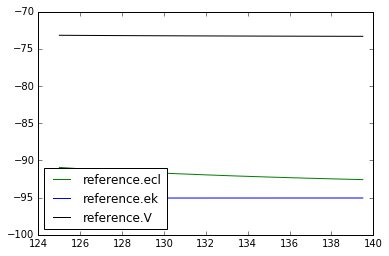

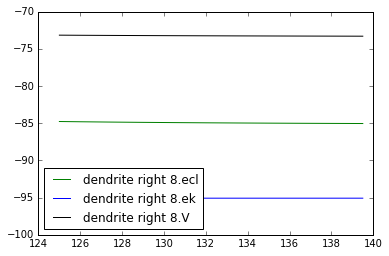

Ion concentrations immediately after event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.003720194969369548	0.003872950985741771	0.004937976901242255	
ki        0.122647915331445673	0.122660534508241770	0.122754983393236414	
nai       0.014029560221109481	0.014029483279570626	0.014022467953386356	
xi        0.156599983684736654	0.156434931987489423	0.155284115128475009	
pkcc2     0.000000620728539999	0.000000020728539769	0.000000020728539769	
gx        0.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000001245	0.000000000000001246	0.000000000000001256	
ecl       -0.092617131877437892	-0.091541633611197687	-0.085048688574822257	
V         -0.073326680738417388	-0.073326840824707848	-0.073307773494712999	
z         -0.849999999999999867	-0.850000000000000089	-0.850000000000000089	
running from 140.000000 s until 170.000000 s with time step of 1e-06 seconds 
time taken: 92866.489373

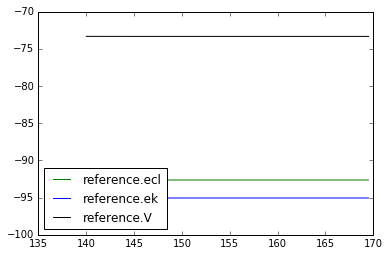

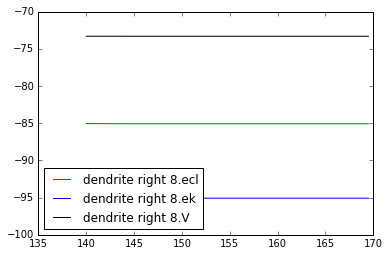

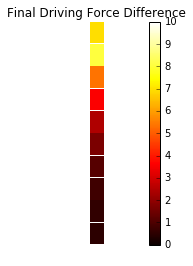

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


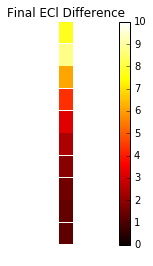

Radii: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


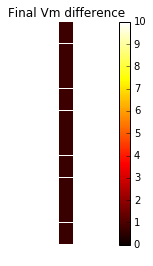

In [3]:
print("Figure 7B")
[sim, gui] = baserun(cli_D=0.203,new_gx=0, jkccup=1e-14, anion_flux=False, default_xz=-1, nrcomps=7, dz=0, textra=time_per_sim)

## Figure 8a,b

Figure 8A
Compartment reference not osmo-neutral
Compartment dendrite left not osmo-neutral
Compartment dendrite right 1 not osmo-neutral
Compartment dendrite right 2 not osmo-neutral
Compartment dendrite right 3 not osmo-neutral
Compartment dendrite right 4 not osmo-neutral
Compartment dendrite right 5 not osmo-neutral
Compartment dendrite right 6 not osmo-neutral
Compartment dendrite right 7 not osmo-neutral
Compartment dendrite right 8 not osmo-neutral
running from 170.000000 s until 100.000000 s with time step of 0.001 seconds 
time taken: 92905.767463
dendrite left<-reference
reference<-dendrite right 1
dendrite right 1<-dendrite right 2
dendrite right 2<-dendrite right 3
dendrite right 3<-dendrite right 4
dendrite right 4<-dendrite right 5
dendrite right 5<-dendrite right 6
dendrite right 6<-dendrite right 7
dendrite right 7<-dendrite right 8
running from 100.000000 s until 110.000000 s with time step of 0.001 seconds 
time taken: 92913.893681
Ion concentrations given diffusion b

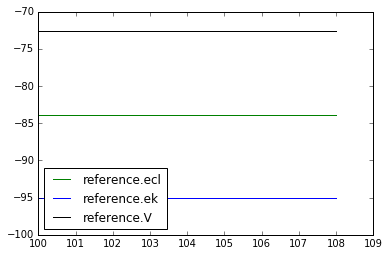

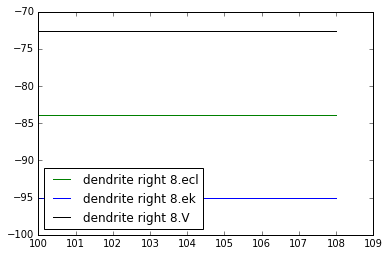

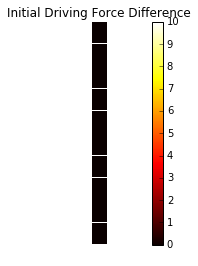

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


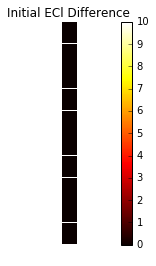

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


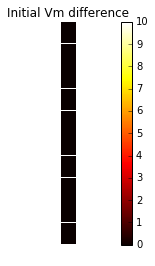

running from 110.000000 s until 125.000000 s with time step of 1e-06 seconds 
time taken: 104376.625611
Ion concentrations during event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.004705030603056480	0.004752184578306651	0.004792457431734560	
ki        0.123922193099992695	0.122728438295414591	0.122703944721431826	
nai       0.014166316152422727	0.014032037102529600	0.014059851837315550	
xi        0.157040568462704228	0.155489650855146627	0.155445845475687155	
pkcc2     0.000000020728539769	0.000000020728539769	0.000000020728539769	
gx        1.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000003086	0.000000000000001254	0.000000000000001254	
ecl       -0.086340212250848508	-0.086073690178037246	-0.085848146900423722	
V         -0.076359328705923296	-0.076097182036975172	-0.075971565960949547	
z         -0.850000000000000089	-0.849999999999999867	-0.849999999999999978	
Radii: [1

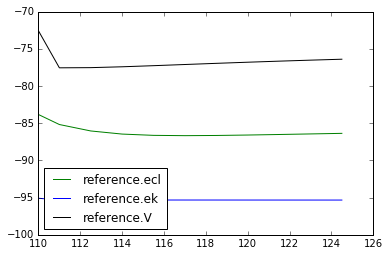

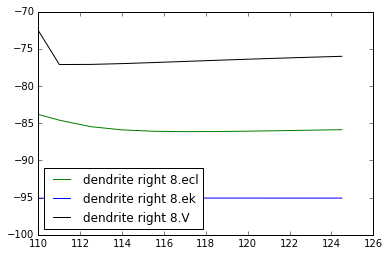

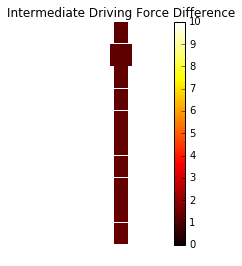

Radii: [19, 31, 19, 19, 19, 19, 19, 19, 19, 19]


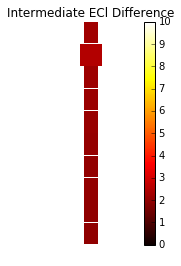

Radii: [19, 31, 19, 19, 19, 19, 19, 19, 19, 19]


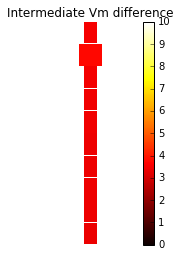

running from 125.000000 s until 140.000000 s with time step of 1e-06 seconds 
time taken: 115921.343317


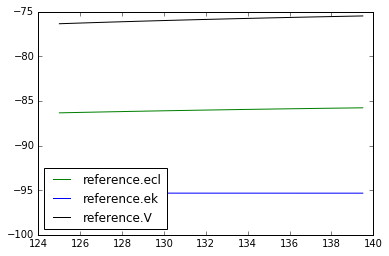

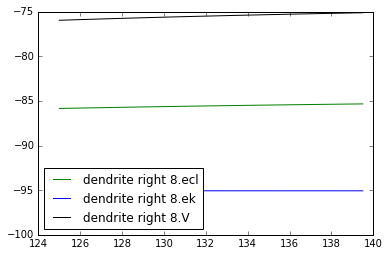

Ion concentrations immediately after event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.004808085163549016	0.004856422893000945	0.004887240712760351	
ki        0.123952862449898712	0.122745956469533041	0.122727416571256506	
nai       0.014159790495220658	0.014023577633871628	0.014044672841780233	
xi        0.156914852068463534	0.155375416438873759	0.155341917898896231	
pkcc2     0.000000020728539769	0.000000020728539769	0.000000020728539769	
gx        1.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000005761	0.000000000000001255	0.000000000000001255	
ecl       -0.085761135696607718	-0.085493782944861305	-0.085324717197982528	
V         -0.075463813829562534	-0.075199743856330395	-0.075106003463263182	
z         -0.849999999999999978	-0.849999999999999978	-0.849999999999999867	
running from 140.000000 s until 170.000000 s with time step of 1e-06 seconds 
time taken: 138835.84129

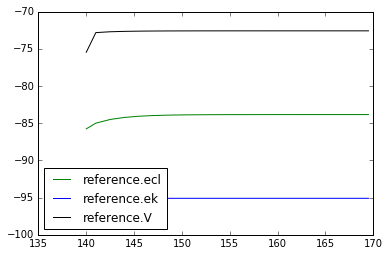

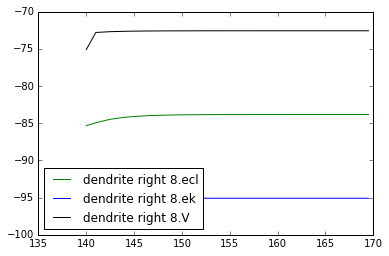

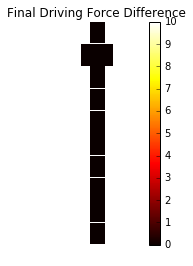

Radii: [20, 43, 20, 20, 20, 20, 20, 20, 20, 20]


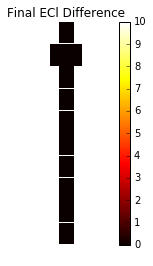

Radii: [20, 43, 20, 20, 20, 20, 20, 20, 20, 20]


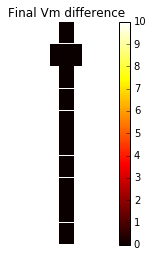

In [4]:
print("Figure 8A")
[sim, gui] = baserun(new_gx=1, jkccup=None, anion_flux=False, default_xz=-1, nrcomps=7, dz=0, textra=time_per_sim)

Figure 8B
Compartment reference not osmo-neutral
Compartment dendrite left not osmo-neutral
Compartment dendrite right 1 not osmo-neutral
Compartment dendrite right 2 not osmo-neutral
Compartment dendrite right 3 not osmo-neutral
Compartment dendrite right 4 not osmo-neutral
Compartment dendrite right 5 not osmo-neutral
Compartment dendrite right 6 not osmo-neutral
Compartment dendrite right 7 not osmo-neutral
Compartment dendrite right 8 not osmo-neutral
running from 170.000000 s until 100.000000 s with time step of 0.001 seconds 
time taken: 138874.702597
dendrite left<-reference
reference<-dendrite right 1
dendrite right 1<-dendrite right 2
dendrite right 2<-dendrite right 3
dendrite right 3<-dendrite right 4
dendrite right 4<-dendrite right 5
dendrite right 5<-dendrite right 6
dendrite right 6<-dendrite right 7
dendrite right 7<-dendrite right 8
running from 100.000000 s until 110.000000 s with time step of 0.001 seconds 
time taken: 138882.654648
Ion concentrations given diffusion

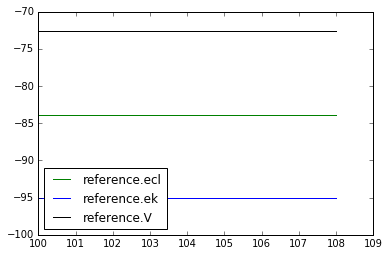

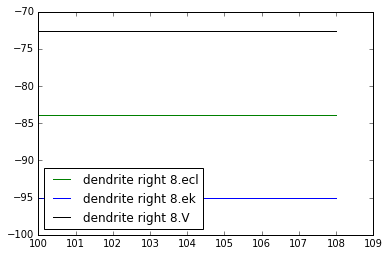

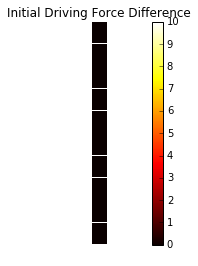

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


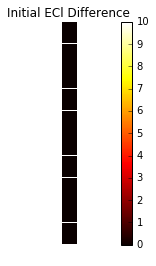

Radii: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


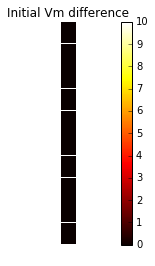

Anion flux with fixed anions having net charge -0.84693877551 while a proportion of 0.020000000000000018 of all impermeants are temporarily mobile anions of charge -1
running from 110.000000 s until 125.000000 s with time step of 1e-06 seconds 
time taken: 150427.463382
Ion concentrations during event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.004420863371457314	0.004704829787434675	0.004748106268962713	
ki        0.130645598149338876	0.122796440075637781	0.122716991224286850	
nai       0.014845451539175847	0.013959794662568361	0.014042827942379273	
xi        0.150141066804223955	0.155541640353185712	0.155494553410138292	
pkcc2     0.000000020728539769	0.000000020728539769	0.000000020728539769	
gx        1.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000003260	0.000000000000001253	0.000000000000001254	
ecl       -0.088005209561409725	-0.086341353005761762	-0.0860966367545762

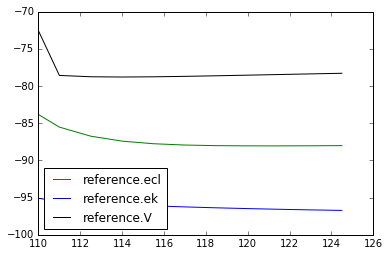

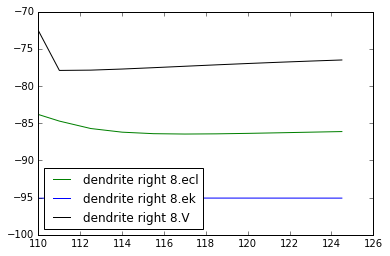

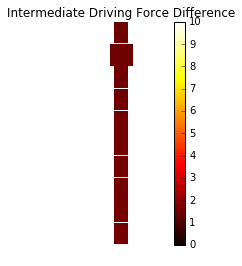

Radii: [19, 32, 19, 19, 19, 19, 19, 19, 19, 19]


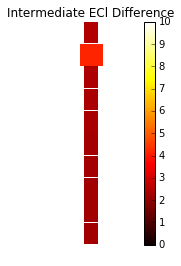

Radii: [19, 32, 19, 19, 19, 19, 19, 19, 19, 19]


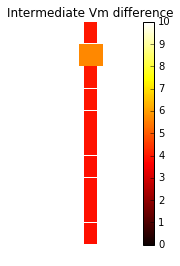

running from 125.000000 s until 140.000000 s with time step of 1e-06 seconds 
time taken: 162004.858186


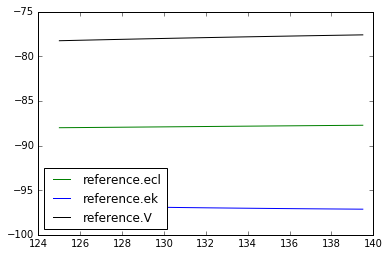

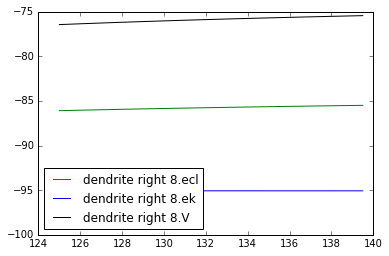

Ion concentrations immediately after event from the dendritic compartment
          	     reference      	   dendrite left    	  dendrite right 8  	
cli       0.004468183546985047	0.004824956792130184	0.004858041769748586	
ki        0.132594804841672548	0.122816633199786418	0.122745006661072048	
nai       0.015054738874942205	0.013950049057446720	0.014024429571677932	
xi        0.147936914866743818	0.155409924284711065	0.155373949633989983	
pkcc2     0.000000020728539769	0.000000020728539769	0.000000020728539769	
gx        1.000000000000000000	0.000000000000000000	0.000000000000000000	
w         0.000000000000006244	0.000000000000001255	0.000000000000001255	
ecl       -0.087720652221171883	-0.085667515721453133	-0.085484875166440683	
V         -0.077586146465212918	-0.075537201506525736	-0.075426656018130200	
z         -0.968341855921673211	-0.849999999999999867	-0.850000000000000089	
running from 140.000000 s until 170.000000 s with time step of 1e-06 seconds 
time taken: 185104.83054

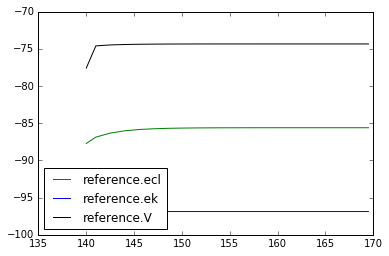

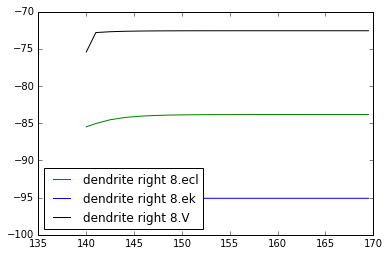

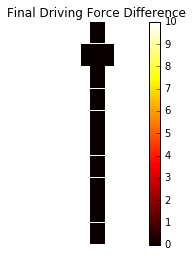

Radii: [20, 44, 20, 20, 20, 20, 20, 20, 20, 20]


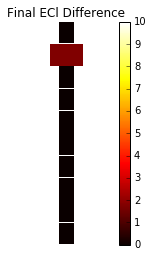

Radii: [20, 44, 20, 20, 20, 20, 20, 20, 20, 20]


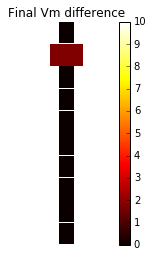

In [5]:
print("Figure 8B")
[sim, gui] = baserun(new_gx=1, jkccup=None, anion_flux=True, default_xz=-1, nrcomps=7, dz=0, textra=time_per_sim)